# ANÁLISIS PROFUNDO: Eventos E0 (2004-2025) - FIXED

**Objetivo**: Análisis exhaustivo de TODOS los eventos en watchlists (no solo info_rich)

**CORRECCIÓN CRÍTICA**: Analizamos TODOS los registros para ver combinaciones reales de filtros

**Preguntas clave**:
1. ¿Qué combinaciones de filtros existen en TODOS los datos? (4, 3, 2, 1, 0)
2. ¿Cuántos eventos E0 (4 filtros) tiene cada ticker?
3. ¿Cuándo se cumplen los 4 filtros a la vez? (fecha exacta para TradingView)
4. ¿Cuál es el mejor día del mes?
5. ¿Cuál es el mejor mes del año?
6. ¿Cuál fue el mejor año?

**Filtros E0 evaluados**:
- **F1**: RVOL ≥ 2.0 (volumen relativo)
- **F2**: |%chg| ≥ 15% (cambio precio)
- **F3**: $vol ≥ $5M (dollar volume)
- **F4**: Precio $0.20-$20 (rango small caps)

---

In [1]:
import polars as pl
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Config
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['font.size'] = 11

# Paths
PROJECT_ROOT = Path(r"D:\04_TRADING_SMALLCAPS")
WATCHLISTS = PROJECT_ROOT / "processed" / "universe" / "info_rich" / "daily"
OUTPUT_DIR = PROJECT_ROOT / "01_DayBook" / "fase_01" / "C_v2_ingesta_tiks_2004_2025" / "notebooks"

print("✅ Setup complete")
print(f"📂 Watchlists: {WATCHLISTS}")
print(f"📂 Output: {OUTPUT_DIR}")

✅ Setup complete
📂 Watchlists: D:\04_TRADING_SMALLCAPS\processed\universe\info_rich\daily
📂 Output: D:\04_TRADING_SMALLCAPS\01_DayBook\fase_01\C_v2_ingesta_tiks_2004_2025\notebooks


---

## 1. CARGA DE DATOS: TODOS los Registros (NO solo info_rich)

In [2]:
print("="*80)
print("CARGANDO TODOS LOS REGISTROS DE WATCHLISTS")
print("="*80)

# Cargar TODOS los registros (no filtrar por info_rich)
print("\n📊 Cargando TODOS los registros...")
df_all = pl.scan_parquet(WATCHLISTS / "date=*" / "watchlist.parquet").collect()

print(f"\n✅ Total registros cargados: {len(df_all):,}")
print(f"   Columnas: {df_all.columns}")
print(f"   Memoria: {df_all.estimated_size('mb'):.2f} MB")
print(f"   Tickers únicos: {df_all['ticker'].n_unique():,}")
print(f"   Días únicos: {df_all['trading_day'].n_unique():,}")
print(f"   Rango temporal: {df_all['trading_day'].min()} → {df_all['trading_day'].max()}")

# Verificar columna info_rich
e0_count = (df_all['info_rich'] == True).sum()
print(f"\n📊 Eventos marcados como E0 (info_rich=True): {e0_count:,} ({e0_count/len(df_all)*100:.2f}%)")

# Sample
print(f"\n📋 Sample (5 filas random):")
print(df_all.sample(5).select(['ticker', 'trading_day', 'rvol30', 'pctchg_d', 'dollar_vol_d', 'close_d', 'info_rich']))

CARGANDO TODOS LOS REGISTROS DE WATCHLISTS

📊 Cargando TODOS los registros...

✅ Total registros cargados: 8,696,865
   Columnas: ['ticker', 'trading_day', 'close_d', 'pctchg_d', 'rvol30', 'vol_d', 'dollar_vol_d', 'vwap_d', 'market_cap_d', 'r_rvol', 'r_chg', 'r_dvol', 'r_px', 'info_rich']
   Memoria: 467.23 MB
   Tickers únicos: 7,948
   Días únicos: 5,934
   Rango temporal: 2004-01-02 → 2025-10-21

📊 Eventos marcados como E0 (info_rich=True): 29,555 (0.34%)

📋 Sample (5 filas random):
shape: (5, 7)
┌────────┬─────────────┬──────────┬───────────┬──────────────┬─────────┬───────────┐
│ ticker ┆ trading_day ┆ rvol30   ┆ pctchg_d  ┆ dollar_vol_d ┆ close_d ┆ info_rich │
│ ---    ┆ ---         ┆ ---      ┆ ---       ┆ ---          ┆ ---     ┆ ---       │
│ str    ┆ date        ┆ f64      ┆ f64       ┆ f64          ┆ f64     ┆ bool      │
╞════════╪═════════════╪══════════╪═══════════╪══════════════╪═════════╪═══════════╡
│ CSP    ┆ 2012-11-06  ┆ 0.902106 ┆ -0.001305 ┆ 671965.534   ┆ 7.65   

---

## 2. EVALUAR FILTROS EN TODOS LOS REGISTROS

**CLAVE**: Evaluamos filtros en TODOS los datos, no solo en info_rich=True

EVALUACIÓN DE FILTROS EN TODOS LOS REGISTROS

Total registros: 8,696,865

Filtro                         Cumple          %         
-------------------------------------------------------
F1: RVOL ≥ 2.0                        766,569      8.81%
F2: |%chg| ≥ 15%                      129,540      1.49%
F3: $vol ≥ $5M                      1,454,397     16.72%
F4: Precio $0.20-$20                8,696,865    100.00%


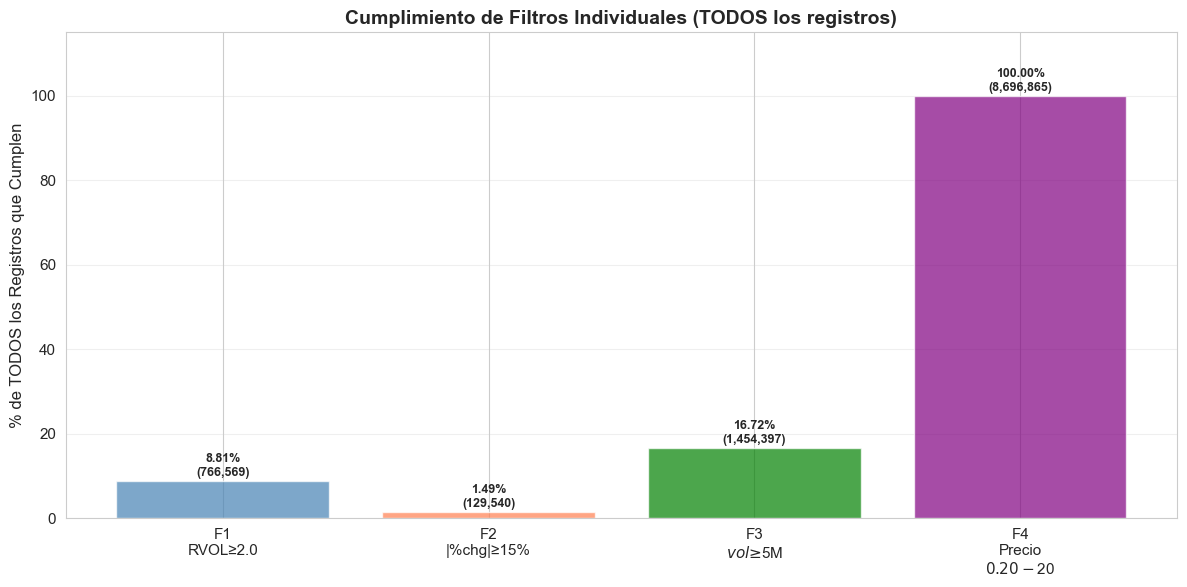


✅ Gráfico guardado: e0_filtros_individuales_FIXED.png


In [3]:
print("="*80)
print("EVALUACIÓN DE FILTROS EN TODOS LOS REGISTROS")
print("="*80)

# Evaluar cada filtro en TODOS los registros
df_all = df_all.with_columns([
    (pl.col('rvol30') >= 2.0).fill_null(False).alias('f1_rvol'),
    (pl.col('pctchg_d').abs() >= 0.15).fill_null(False).alias('f2_pctchg'),
    (pl.col('dollar_vol_d') >= 5_000_000).fill_null(False).alias('f3_dvol'),
    ((pl.col('close_d') >= 0.20) & (pl.col('close_d') <= 20.0)).fill_null(False).alias('f4_price')
])

# Contar cuántos filtros cumple cada registro
df_all = df_all.with_columns(
    (pl.col('f1_rvol').cast(pl.Int32) + 
     pl.col('f2_pctchg').cast(pl.Int32) + 
     pl.col('f3_dvol').cast(pl.Int32) + 
     pl.col('f4_price').cast(pl.Int32)).alias('num_filtros')
)

# Estadísticas de filtros individuales
total = len(df_all)
f1_count = df_all['f1_rvol'].sum()
f2_count = df_all['f2_pctchg'].sum()
f3_count = df_all['f3_dvol'].sum()
f4_count = df_all['f4_price'].sum()

print(f"\nTotal registros: {total:,}")
print(f"\n{'Filtro':<30} {'Cumple':<15} {'%':<10}")
print("-"*55)
print(f"{'F1: RVOL ≥ 2.0':<30} {f1_count:>14,} {f1_count/total*100:>9.2f}%")
print(f"{'F2: |%chg| ≥ 15%':<30} {f2_count:>14,} {f2_count/total*100:>9.2f}%")
print(f"{'F3: $vol ≥ $5M':<30} {f3_count:>14,} {f3_count/total*100:>9.2f}%")
print(f"{'F4: Precio $0.20-$20':<30} {f4_count:>14,} {f4_count/total*100:>9.2f}%")

# Gráfico
fig, ax = plt.subplots(figsize=(12, 6))
filtros = ['F1\nRVOL≥2.0', 'F2\n|%chg|≥15%', 'F3\n$vol≥$5M', 'F4\nPrecio\n$0.20-$20']
counts = [f1_count, f2_count, f3_count, f4_count]
percentages = [c/total*100 for c in counts]

bars = ax.bar(filtros, percentages, color=['steelblue', 'coral', 'green', 'purple'], alpha=0.7)
ax.set_ylabel('% de TODOS los Registros que Cumplen', fontsize=12)
ax.set_title('Cumplimiento de Filtros Individuales (TODOS los registros)', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(percentages) * 1.15)
ax.grid(axis='y', alpha=0.3)

for bar, pct, cnt in zip(bars, percentages, counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{pct:.2f}%\n({cnt:,})',
            ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'e0_filtros_individuales_FIXED.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Gráfico guardado: e0_filtros_individuales_FIXED.png")

---

## 3. COMBINACIONES DE FILTROS

**Pregunta**: De TODOS los registros, ¿cuántos cumplen 4, 3, 2, 1, 0 filtros?

COMBINACIONES DE FILTROS (TODOS LOS REGISTROS)

# Filtros       Eventos         %         
----------------------------------------
4                       29,555      0.34% (E0 = info_rich)
3                      225,742      2.60% 
2                    1,810,357     20.82% 
1                    6,631,211     76.25% 

🔍 VERIFICACIÓN:
   Eventos con 4 filtros: 29,555
   Eventos info_rich=True: 29,555
   Match: ✅


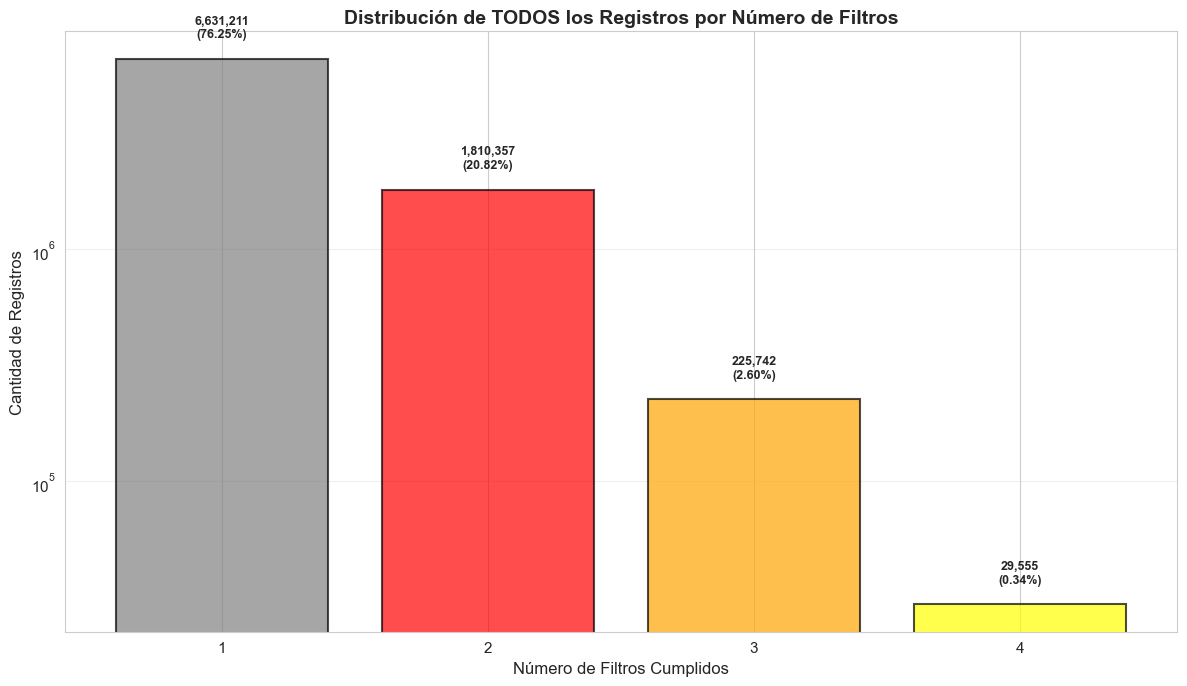


✅ Gráfico guardado: e0_distribucion_filtros_FIXED.png


In [4]:
print("="*80)
print("COMBINACIONES DE FILTROS (TODOS LOS REGISTROS)")
print("="*80)

# Distribución por número de filtros
dist_filtros = df_all.group_by('num_filtros').agg(pl.count().alias('count')).sort('num_filtros', descending=True)

print(f"\n{'# Filtros':<15} {'Eventos':<15} {'%':<10}")
print("-"*40)
for row in dist_filtros.iter_rows(named=True):
    num = row['num_filtros']
    cnt = row['count']
    pct = cnt/total*100
    label = "(E0 = info_rich)" if num == 4 else ""
    print(f"{num:<15} {cnt:>14,} {pct:>9.2f}% {label}")

# Verificar que 4 filtros == info_rich
eventos_4_filtros = (df_all['num_filtros'] == 4).sum()
eventos_info_rich = (df_all['info_rich'] == True).sum()
print(f"\n🔍 VERIFICACIÓN:")
print(f"   Eventos con 4 filtros: {eventos_4_filtros:,}")
print(f"   Eventos info_rich=True: {eventos_info_rich:,}")
print(f"   Match: {'✅' if eventos_4_filtros == eventos_info_rich else '❌'}")

# Gráfico
fig, ax = plt.subplots(figsize=(12, 7))
dist_pd = dist_filtros.to_pandas().sort_values('num_filtros')

colors = ['gray', 'red', 'orange', 'yellow', 'lightgreen', 'darkgreen']
bars = ax.bar(dist_pd['num_filtros'].astype(str), dist_pd['count'], 
              color=colors[:len(dist_pd)], alpha=0.7, edgecolor='black', linewidth=1.5)

ax.set_xlabel('Número de Filtros Cumplidos', fontsize=12)
ax.set_ylabel('Cantidad de Registros', fontsize=12)
ax.set_title('Distribución de TODOS los Registros por Número de Filtros', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.set_yscale('log')  # Escala log para ver mejor

for bar in bars:
    height = bar.get_height()
    label = bar.get_x() + bar.get_width()/2.
    if label == 4:  # Destacar eventos E0
        ax.text(bar.get_x() + bar.get_width()/2., height * 1.2,
                f'{int(height):,}\n({height/total*100:.2f}%)\n⭐ E0',
                ha='center', va='bottom', fontweight='bold', fontsize=10, color='darkgreen')
    else:
        ax.text(bar.get_x() + bar.get_width()/2., height * 1.2,
                f'{int(height):,}\n({height/total*100:.2f}%)',
                ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'e0_distribucion_filtros_FIXED.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Gráfico guardado: e0_distribucion_filtros_FIXED.png")

---

## 4. ANÁLISIS DETALLADO: Combinaciones Específicas

**Pregunta**: ¿Qué combinaciones específicas de 3, 2, 1 filtros son más comunes?

In [5]:
print("="*80)
print("COMBINACIONES ESPECÍFICAS DE FILTROS")
print("="*80)

# Crear columna de combinación como string
df_all = df_all.with_columns(
    (pl.when(pl.col('f1_rvol')).then(pl.lit('F1')).otherwise(pl.lit('')) +
     pl.when(pl.col('f2_pctchg')).then(pl.lit('+F2')).otherwise(pl.lit('')) +
     pl.when(pl.col('f3_dvol')).then(pl.lit('+F3')).otherwise(pl.lit('')) +
     pl.when(pl.col('f4_price')).then(pl.lit('+F4')).otherwise(pl.lit(''))
    ).str.replace_all('^\\+', '').str.replace_all('\\+$', '').alias('combinacion')
)

# Eventos con 3 filtros
print("\n📊 EVENTOS CON 3 FILTROS (falta 1):")
df_3 = df_all.filter(pl.col('num_filtros') == 3)
comb_3 = df_3.group_by('combinacion').agg(pl.count().alias('count')).sort('count', descending=True)
print(comb_3.head(10))

# Eventos con 2 filtros
print("\n📊 EVENTOS CON 2 FILTROS:")
df_2 = df_all.filter(pl.col('num_filtros') == 2)
comb_2 = df_2.group_by('combinacion').agg(pl.count().alias('count')).sort('count', descending=True)
print(comb_2.head(10))

# Eventos con 1 filtro
print("\n📊 EVENTOS CON 1 FILTRO:")
df_1 = df_all.filter(pl.col('num_filtros') == 1)
comb_1 = df_1.group_by('combinacion').agg(pl.count().alias('count')).sort('count', descending=True)
print(comb_1)

print("\n💡 INTERPRETACIÓN:")
print("   - Combinaciones más comunes muestran qué filtros se cumplen juntos")
print("   - Útil para ajustar thresholds y crear filtros alternativos")

COMBINACIONES ESPECÍFICAS DE FILTROS

📊 EVENTOS CON 3 FILTROS (falta 1):
shape: (3, 2)
┌─────────────┬────────┐
│ combinacion ┆ count  │
│ ---         ┆ ---    │
│ str         ┆ u32    │
╞═════════════╪════════╡
│ F1+F3+F4    ┆ 176813 │
│ F1+F2+F4    ┆ 38347  │
│ F2+F3+F4    ┆ 10582  │
└─────────────┴────────┘

📊 EVENTOS CON 2 FILTROS:
shape: (3, 2)
┌─────────────┬─────────┐
│ combinacion ┆ count   │
│ ---         ┆ ---     │
│ str         ┆ u32     │
╞═════════════╪═════════╡
│ F3+F4       ┆ 1237447 │
│ F1+F4       ┆ 521854  │
│ F2+F4       ┆ 51056   │
└─────────────┴─────────┘

📊 EVENTOS CON 1 FILTRO:
shape: (1, 2)
┌─────────────┬─────────┐
│ combinacion ┆ count   │
│ ---         ┆ ---     │
│ str         ┆ u32     │
╞═════════════╪═════════╡
│ F4          ┆ 6631211 │
└─────────────┴─────────┘

💡 INTERPRETACIÓN:
   - Combinaciones más comunes muestran qué filtros se cumplen juntos
   - Útil para ajustar thresholds y crear filtros alternativos


---

## 5. EVENTOS E0 (4 FILTROS): Análisis por Ticker

EVENTOS E0 (4 FILTROS) POR TICKER

✅ Total eventos E0 (4 filtros): 29,555
   Tickers únicos: 4,898

📊 Estadísticas de eventos E0 por ticker:
   Min: 1
   Q1: 2
   Mediana: 4
   Q3: 8
   Max: 63
   Media: 6.03

📊 Distribución de tickers por # eventos E0:
   1-1 eventos: 1,009 tickers (20.6%)
   2-4 eventos: 1,601 tickers (32.7%)
   5-9 eventos: 1,349 tickers (27.5%)
   10-19 eventos: 742 tickers (15.1%)
   20-49 eventos: 193 tickers (3.9%)
   50-99 eventos: 4 tickers (0.1%)
   100+ eventos: 0 tickers (0.0%)

📊 TOP 30 Tickers con Más Eventos E0:
shape: (30, 2)
┌────────┬──────────────────┐
│ ticker ┆ total_eventos_e0 │
│ ---    ┆ ---              │
│ str    ┆ u32              │
╞════════╪══════════════════╡
│ BCRX   ┆ 63               │
│ GERN   ┆ 53               │
│ VXRT   ┆ 51               │
│ SRNE   ┆ 50               │
│ BLDP   ┆ 43               │
│ …      ┆ …                │
│ GALT   ┆ 34               │
│ TLRY   ┆ 34               │
│ BBBY   ┆ 34               │
│ OSTK   ┆ 34  

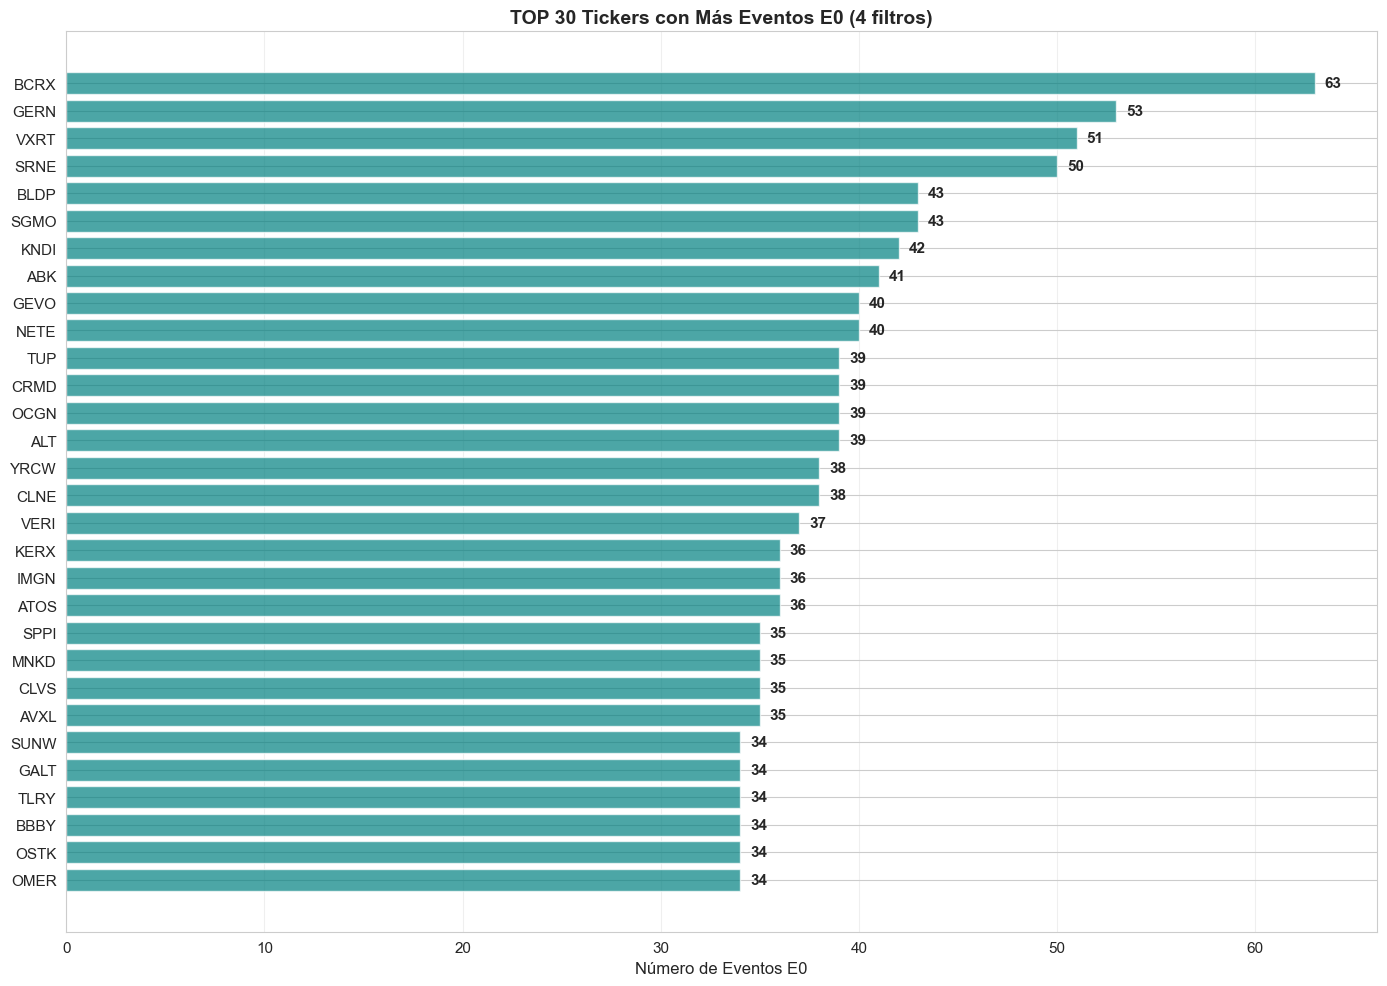


✅ Gráfico guardado: e0_top30_tickers_FIXED.png


In [6]:
# En la celda 5 - EVENTOS E0 (4 FILTROS): Análisis por Ticker
print("="*80)
print("EVENTOS E0 (4 FILTROS) POR TICKER")
print("="*80)

# Filtrar SOLO eventos con 4 filtros (E0)
df_e0 = df_all.filter(pl.col('num_filtros') == 4)

# AGREGAR ESTA LÍNEA:
total_e0 = len(df_e0)  # ✅ Definir aquí para uso en celdas posteriores

print(f"\n✅ Total eventos E0 (4 filtros): {len(df_e0):,}")  # o usar {total_e0:,}
print(f"   Tickers únicos: {df_e0['ticker'].n_unique():,}")

# Estadísticas por ticker
by_ticker = (df_e0.group_by('ticker')
             .agg(pl.count().alias('total_eventos_e0'))
             .sort('total_eventos_e0', descending=True))

print(f"\n📊 Estadísticas de eventos E0 por ticker:")
eventos_stats = by_ticker['total_eventos_e0']
print(f"   Min: {eventos_stats.min()}")
print(f"   Q1: {eventos_stats.quantile(0.25):.0f}")
print(f"   Mediana: {eventos_stats.median():.0f}")
print(f"   Q3: {eventos_stats.quantile(0.75):.0f}")
print(f"   Max: {eventos_stats.max()}")
print(f"   Media: {eventos_stats.mean():.2f}")

# Distribución
print(f"\n📊 Distribución de tickers por # eventos E0:")
bins = [1, 2, 5, 10, 20, 50, 100]
for i in range(len(bins)-1):
    count = ((eventos_stats >= bins[i]) & (eventos_stats < bins[i+1])).sum()
    print(f"   {bins[i]}-{bins[i+1]-1} eventos: {count:,} tickers ({count/len(by_ticker)*100:.1f}%)")
count_100plus = (eventos_stats >= 100).sum()
print(f"   100+ eventos: {count_100plus:,} tickers ({count_100plus/len(by_ticker)*100:.1f}%)")

# TOP 30
top30 = by_ticker.head(30)
print(f"\n📊 TOP 30 Tickers con Más Eventos E0:")
print(top30)

# Gráfico
fig, ax = plt.subplots(figsize=(14, 10))
top30_pd = top30.to_pandas()

ax.barh(range(len(top30_pd)), top30_pd['total_eventos_e0'], color='teal', alpha=0.7)
ax.set_yticks(range(len(top30_pd)))
ax.set_yticklabels(top30_pd['ticker'])
ax.set_xlabel('Número de Eventos E0', fontsize=12)
ax.set_title('TOP 30 Tickers con Más Eventos E0 (4 filtros)', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

for i, count in enumerate(top30_pd['total_eventos_e0']):
    ax.text(count + 0.5, i, f'{count}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'e0_top30_tickers_FIXED.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Gráfico guardado: e0_top30_tickers_FIXED.png")

---

## 6. ANÁLISIS TEMPORAL: ¿Cuándo ocurren los eventos E0?

ANÁLISIS TEMPORAL: EVENTOS E0

📊 DISTRIBUCIÓN POR AÑO:
   2004:    407 eventos ( 1.38%)
   2005:    375 eventos ( 1.27%)
   2006:    362 eventos ( 1.22%)
   2007:    442 eventos ( 1.50%)
   2008:  1,014 eventos ( 3.43%)
   2009:    966 eventos ( 3.27%)
   2010:    472 eventos ( 1.60%)
   2011:    536 eventos ( 1.81%)
   2012:    494 eventos ( 1.67%)
   2013:    597 eventos ( 2.02%)
   2014:    633 eventos ( 2.14%)
   2015:    776 eventos ( 2.63%)
   2016:  1,127 eventos ( 3.81%)
   2017:  1,086 eventos ( 3.67%)
   2018:  1,148 eventos ( 3.88%)
   2019:  1,284 eventos ( 4.34%)
   2020:  3,267 eventos (11.05%)
   2021:  2,053 eventos ( 6.95%)
   2022:  2,220 eventos ( 7.51%)
   2023:  2,588 eventos ( 8.76%)
   2024:  3,527 eventos (11.93%)
   2025:  4,181 eventos (14.15%)

📊 DISTRIBUCIÓN POR MES:
   Ene:  2,237 eventos ( 7.57%)
   Feb:  2,397 eventos ( 8.11%)
   Mar:  2,992 eventos (10.12%)
   Abr:  2,106 eventos ( 7.13%)
   May:  2,723 eventos ( 9.21%)
   Jun:  2,315 eventos ( 7.83%)
  

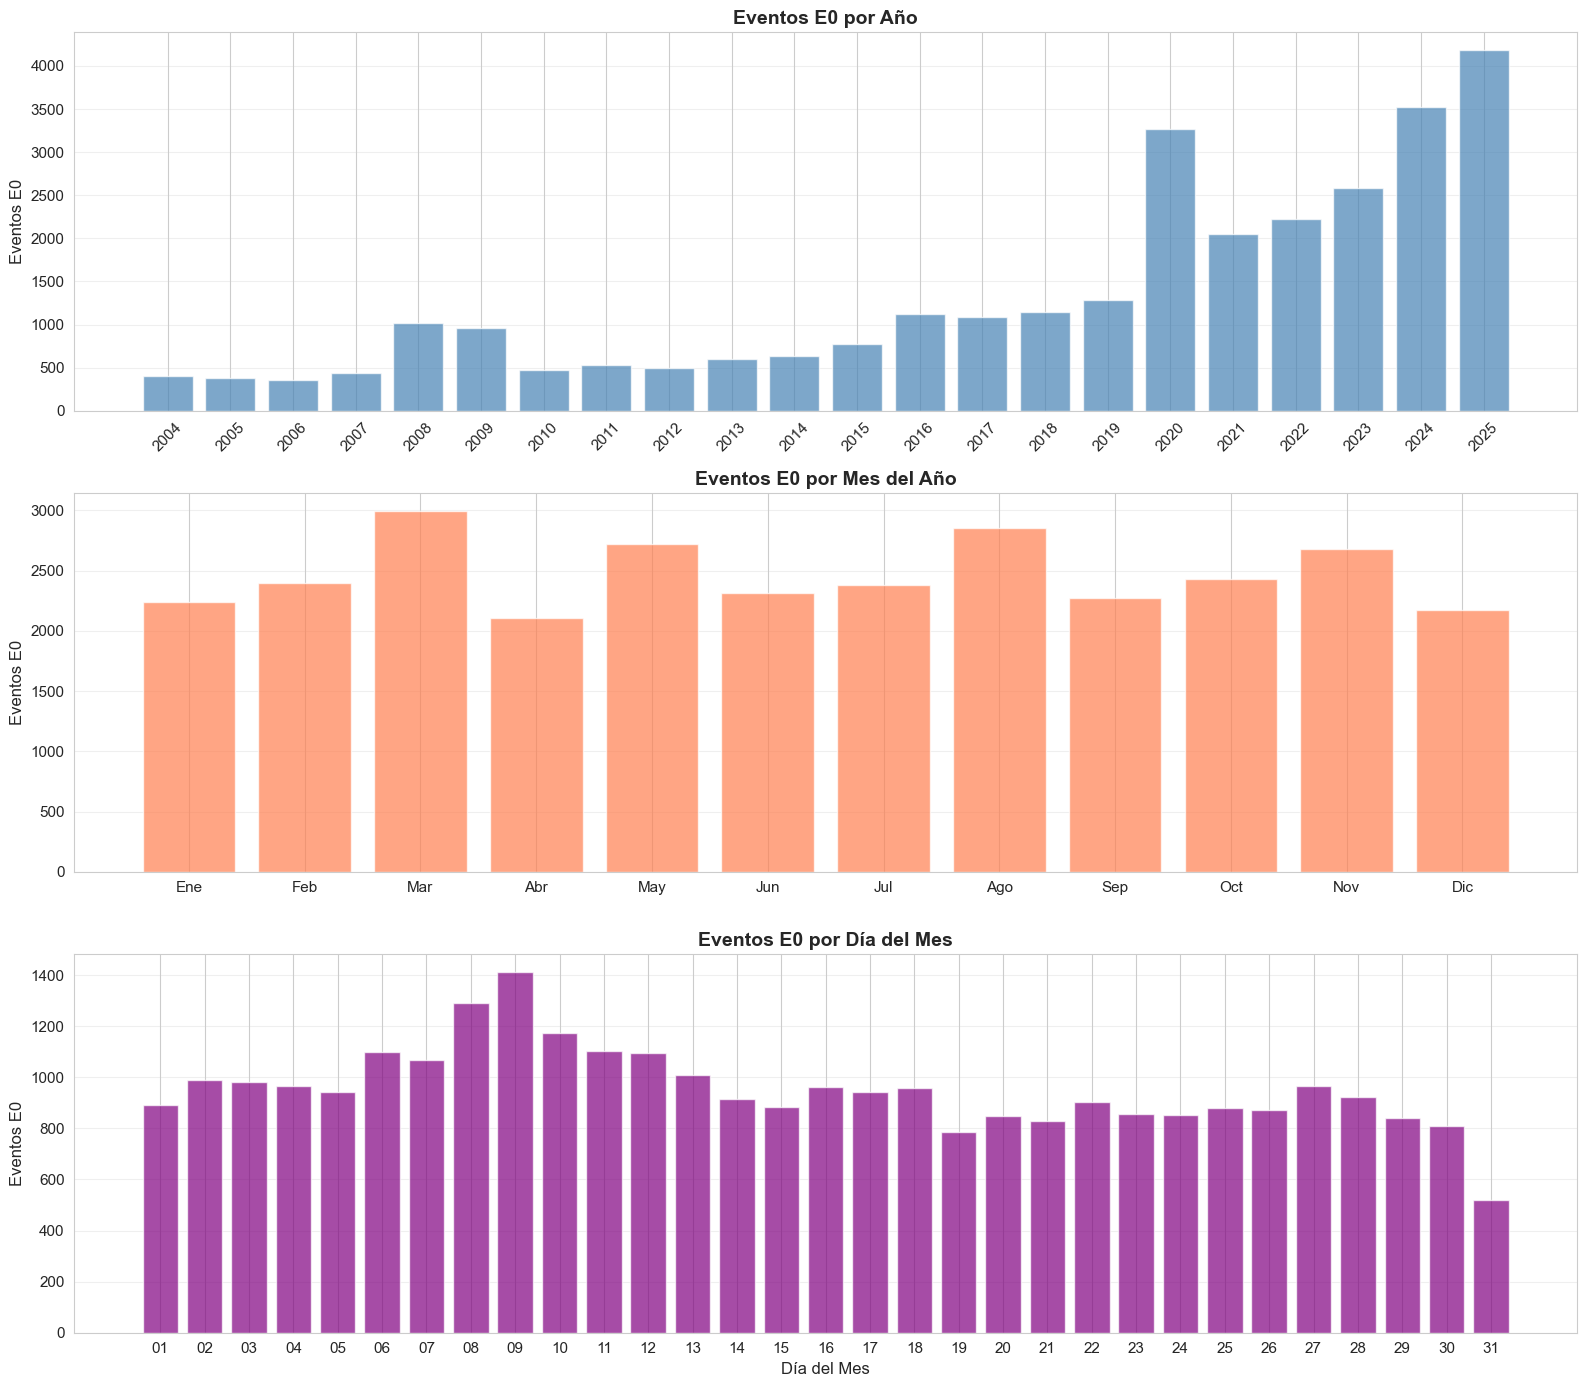


✅ Gráfico guardado: e0_distribucion_temporal_FIXED.png

🏆 MEJORES PERÍODOS:
   Mejor año: 2025 (4,181 eventos)
   Mejor mes: Mar (2,992 eventos)
   Mejor día del mes: Día 09 (1,411 eventos)


In [7]:
print("="*80)
print("ANÁLISIS TEMPORAL: EVENTOS E0")
print("="*80)

# Extraer componentes temporales - CORRECCIÓN: usar dt en vez de str
df_e0 = df_e0.with_columns([
    pl.col('trading_day').dt.year().cast(pl.Utf8).alias('year'),
    pl.col('trading_day').dt.month().cast(pl.Utf8).str.zfill(2).alias('month'),
    pl.col('trading_day').dt.day().cast(pl.Utf8).str.zfill(2).alias('day')
])



# Por año
by_year = df_e0.group_by('year').agg(pl.count().alias('eventos')).sort('year')
print(f"\n📊 DISTRIBUCIÓN POR AÑO:")
for row in by_year.iter_rows(named=True):
    print(f"   {row['year']}: {row['eventos']:>6,} eventos ({row['eventos']/total_e0*100:>5.2f}%)")

# Por mes
by_month = df_e0.group_by('month').agg(pl.count().alias('eventos')).sort('month')
month_names = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
print(f"\n📊 DISTRIBUCIÓN POR MES:")
for row in by_month.iter_rows(named=True):
    month_name = month_names[int(row['month'])-1]
    print(f"   {month_name}: {row['eventos']:>6,} eventos ({row['eventos']/total_e0*100:>5.2f}%)")

# Por día del mes
by_day = df_e0.group_by('day').agg(pl.count().alias('eventos')).sort('day')
print(f"\n📊 TOP 10 DÍAS DEL MES:")
for row in by_day.sort('eventos', descending=True).head(10).iter_rows(named=True):
    print(f"   Día {row['day']}: {row['eventos']:>6,} eventos ({row['eventos']/total_e0*100:>5.2f}%)")

# Gráficos
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 14))

# Año
by_year_pd = by_year.to_pandas()
ax1.bar(by_year_pd['year'], by_year_pd['eventos'], color='steelblue', alpha=0.7)
ax1.set_ylabel('Eventos E0', fontsize=12)
ax1.set_title('Eventos E0 por Año', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Mes
by_month_pd = by_month.to_pandas()
by_month_pd['month_name'] = by_month_pd['month'].apply(lambda x: month_names[int(x)-1])
ax2.bar(by_month_pd['month_name'], by_month_pd['eventos'], color='coral', alpha=0.7)
ax2.set_ylabel('Eventos E0', fontsize=12)
ax2.set_title('Eventos E0 por Mes del Año', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Día
by_day_pd = by_day.to_pandas()
ax3.bar(by_day_pd['day'], by_day_pd['eventos'], color='purple', alpha=0.7)
ax3.set_xlabel('Día del Mes', fontsize=12)
ax3.set_ylabel('Eventos E0', fontsize=12)
ax3.set_title('Eventos E0 por Día del Mes', fontsize=14, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'e0_distribucion_temporal_FIXED.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Gráfico guardado: e0_distribucion_temporal_FIXED.png")

# Mejores períodos
best_year = by_year_pd.loc[by_year_pd['eventos'].idxmax()]
best_month = by_month_pd.loc[by_month_pd['eventos'].idxmax()]
best_day = by_day_pd.loc[by_day_pd['eventos'].idxmax()]

print(f"\n🏆 MEJORES PERÍODOS:")
print(f"   Mejor año: {best_year['year']} ({best_year['eventos']:,} eventos)")
print(f"   Mejor mes: {best_month['month_name']} ({best_month['eventos']:,} eventos)")
print(f"   Mejor día del mes: Día {best_day['day']} ({best_day['eventos']:,} eventos)")

---

## 7. EXPORTAR CSVs PARA TRADINGVIEW

In [8]:
print("="*80)
print("EXPORTANDO CSVs")
print("="*80)

# 1. Eventos E0 (4 filtros) para TradingView
df_export_e0 = df_e0.select([
    'ticker',
    'trading_day',
    'rvol30',
    'pctchg_d',
    'dollar_vol_d',
    'close_d',
    'vol_d',
    'vwap_d'
]).sort(['trading_day', 'ticker'])

csv_e0 = OUTPUT_DIR / 'eventos_E0_4_filtros_TRADINGVIEW.csv'
df_export_e0.write_csv(csv_e0)
print(f"\n✅ CSV 1: {csv_e0.name}")
print(f"   Total eventos E0: {len(df_export_e0):,}")

# 2. Estadísticas por ticker
by_ticker_detailed = (df_e0.group_by('ticker')
                      .agg([
                          pl.count().alias('total_eventos_e0'),
                          pl.col('rvol30').mean().alias('rvol30_promedio'),
                          pl.col('pctchg_d').abs().mean().alias('pctchg_promedio'),
                          pl.col('dollar_vol_d').mean().alias('dvol_promedio'),
                          pl.col('close_d').mean().alias('precio_promedio')
                      ])
                      .sort('total_eventos_e0', descending=True))

csv_ticker = OUTPUT_DIR / 'estadisticas_por_ticker_E0.csv'
by_ticker_detailed.write_csv(csv_ticker)
print(f"\n✅ CSV 2: {csv_ticker.name}")
print(f"   Total tickers: {len(by_ticker_detailed):,}")

# 3. Combinaciones de filtros
dist_filtros_export = df_all.group_by(['num_filtros', 'combinacion']).agg(
    pl.count().alias('count')
).sort(['num_filtros', 'count'], descending=[True, True])

csv_comb = OUTPUT_DIR / 'combinaciones_filtros_E0.csv'
dist_filtros_export.write_csv(csv_comb)
print(f"\n✅ CSV 3: {csv_comb.name}")
print(f"   Total combinaciones únicas: {len(dist_filtros_export):,}")

print(f"\n💡 USO EN TRADINGVIEW:")
print(f"   1. Abrir TradingView")
print(f"   2. Buscar ticker + fecha de eventos_E0_4_filtros_TRADINGVIEW.csv")
print(f"   3. Verificar visualmente que se cumplen los 4 filtros")

EXPORTANDO CSVs

✅ CSV 1: eventos_E0_4_filtros_TRADINGVIEW.csv
   Total eventos E0: 29,555

✅ CSV 2: estadisticas_por_ticker_E0.csv
   Total tickers: 4,898

✅ CSV 3: combinaciones_filtros_E0.csv
   Total combinaciones únicas: 8

💡 USO EN TRADINGVIEW:
   1. Abrir TradingView
   2. Buscar ticker + fecha de eventos_E0_4_filtros_TRADINGVIEW.csv
   3. Verificar visualmente que se cumplen los 4 filtros


---

## 8. RESUMEN EJECUTIVO

In [9]:
print("\n" + "="*80)
print("RESUMEN EJECUTIVO - ANÁLISIS EVENTOS E0 (FIXED)")
print("="*80)

print(f"\n📊 DATOS GENERALES:")
print(f"   Total registros analizados: {total:,}")
print(f"   Rango temporal: {df_all['trading_day'].min()} → {df_all['trading_day'].max()}")

print(f"\n📊 CUMPLIMIENTO DE FILTROS (de todos los registros):")
print(f"   F1 (RVOL≥2.0): {f1_count:,} ({f1_count/total*100:.2f}%)")
print(f"   F2 (|%chg|≥15%): {f2_count:,} ({f2_count/total*100:.2f}%)")
print(f"   F3 ($vol≥$5M): {f3_count:,} ({f3_count/total*100:.2f}%)")
print(f"   F4 (Precio $0.20-$20): {f4_count:,} ({f4_count/total*100:.2f}%)")

print(f"\n📊 DISTRIBUCIÓN POR # FILTROS:")
for row in dist_filtros.iter_rows(named=True):
    num = row['num_filtros']
    cnt = row['count']
    label = "⭐ E0 (info_rich)" if num == 4 else ""
    print(f"   {num} filtros: {cnt:>10,} ({cnt/total*100:>6.2f}%) {label}")

print(f"\n📊 EVENTOS E0 (4 FILTROS):")
print(f"   Total: {total_e0:,}")
print(f"   Tickers únicos: {df_e0['ticker'].n_unique():,}")
print(f"   % del universo: {total_e0/total*100:.2f}%")

print(f"\n🏆 MEJORES PERÍODOS:")
print(f"   Mejor año: {best_year['year']} ({best_year['eventos']:,} eventos)")
print(f"   Mejor mes: {best_month['month_name']} ({best_month['eventos']:,} eventos)")
print(f"   Mejor día del mes: Día {best_day['day']} ({best_day['eventos']:,} eventos)")

print(f"\n📁 ARCHIVOS GENERADOS:")
print(f"   ✅ eventos_E0_4_filtros_TRADINGVIEW.csv ({len(df_export_e0):,} eventos)")
print(f"   ✅ estadisticas_por_ticker_E0.csv ({len(by_ticker_detailed):,} tickers)")
print(f"   ✅ combinaciones_filtros_E0.csv ({len(dist_filtros_export):,} combinaciones)")
print(f"   ✅ e0_filtros_individuales_FIXED.png")
print(f"   ✅ e0_distribucion_filtros_FIXED.png")
print(f"   ✅ e0_top30_tickers_FIXED.png")
print(f"   ✅ e0_distribucion_temporal_FIXED.png")

print(f"\n💡 INSIGHT CLAVE:")
print(f"   Los eventos E0 (4 filtros) representan solo {total_e0/total*100:.2f}% del universo")
print(f"   Esto valida el enfoque event-driven: focalizamos en días info-rich")

print("\n" + "="*80)


RESUMEN EJECUTIVO - ANÁLISIS EVENTOS E0 (FIXED)

📊 DATOS GENERALES:
   Total registros analizados: 8,696,865
   Rango temporal: 2004-01-02 → 2025-10-21

📊 CUMPLIMIENTO DE FILTROS (de todos los registros):
   F1 (RVOL≥2.0): 766,569 (8.81%)
   F2 (|%chg|≥15%): 129,540 (1.49%)
   F3 ($vol≥$5M): 1,454,397 (16.72%)
   F4 (Precio $0.20-$20): 8,696,865 (100.00%)

📊 DISTRIBUCIÓN POR # FILTROS:
   4 filtros:     29,555 (  0.34%) ⭐ E0 (info_rich)
   3 filtros:    225,742 (  2.60%) 
   2 filtros:  1,810,357 ( 20.82%) 
   1 filtros:  6,631,211 ( 76.25%) 

📊 EVENTOS E0 (4 FILTROS):
   Total: 29,555
   Tickers únicos: 4,898
   % del universo: 0.34%

🏆 MEJORES PERÍODOS:
   Mejor año: 2025 (4,181 eventos)
   Mejor mes: Mar (2,992 eventos)
   Mejor día del mes: Día 09 (1,411 eventos)

📁 ARCHIVOS GENERADOS:
   ✅ eventos_E0_4_filtros_TRADINGVIEW.csv (29,555 eventos)
   ✅ estadisticas_por_ticker_E0.csv (4,898 tickers)
   ✅ combinaciones_filtros_E0.csv (8 combinaciones)
   ✅ e0_filtros_individuales_FIXED.

ANÁLISIS INTRADAY: HORA EXACTA DEL TRIGGER E0

📊 Analizando TODOS los eventos E0 con trades tick-by-tick descargados...
   Se procesarán SERIALMENTE (uno por uno) con barra de progreso
   Esto es más lento pero funciona en Windows/Jupyter

✅ Eventos a analizar: 29,555 eventos E0
   Estimado de tiempo: 1-2 horas

🚀 Procesamiento SERIAL iniciando...


Analizando triggers:   0%|          | 0/29555 [00:00<?, ?evento/s]


✅ Análisis completado:
   Eventos analizados: 29,555
   Triggers encontrados: 7,306
   % con trades disponibles: 24.7%

📊 ESTADÍSTICAS DE TRIGGERS:
   Hora promedio trigger: 14.1:33

📊 DISTRIBUCIÓN POR HORA DEL DÍA:
   09:00 - 09:59:      2 triggers (  0.0%)
   10:00 - 10:59:      6 triggers (  0.1%)
   11:00 - 11:59:     20 triggers (  0.3%)
   12:00 - 12:59:    126 triggers (  1.7%)
   13:00 - 13:59:  1,534 triggers ( 21.0%)
   14:00 - 14:59:  2,895 triggers ( 39.6%)
   15:00 - 15:59:  2,688 triggers ( 36.8%)
   16:00 - 16:59:     35 triggers (  0.5%)


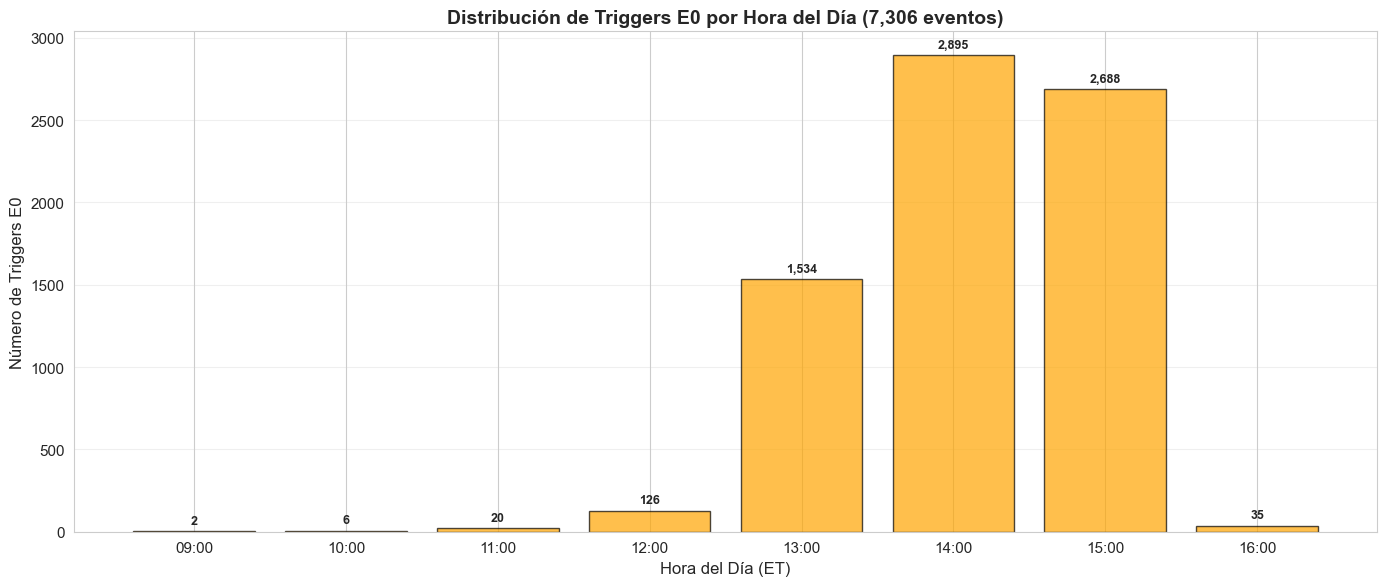


✅ Gráfico guardado: e0_triggers_por_hora_COMPLETO.png

✅ CSV exportado: eventos_E0_CON_HORA_EXACTA_COMPLETO_TRADINGVIEW.csv
   Total triggers: 7,306

📋 Sample (primeros 10):
shape: (10, 8)
┌────────┬────────────┬────────────┬────────────┬────────────┬────────────┬────────────┬───────────┐
│ ticker ┆ date       ┆ trigger_ti ┆ trigger_ho ┆ trigger_mi ┆ pctchg_tri ┆ dvol_trigg ┆ close_tri │
│ ---    ┆ ---        ┆ me         ┆ ur         ┆ nute       ┆ gger       ┆ er         ┆ gger      │
│ str    ┆ str        ┆ ---        ┆ ---        ┆ ---        ┆ ---        ┆ ---        ┆ ---       │
│        ┆            ┆ datetime[μ ┆ i64        ┆ i64        ┆ f64        ┆ f64        ┆ f64       │
│        ┆            ┆ s]         ┆            ┆            ┆            ┆            ┆           │
╞════════╪════════════╪════════════╪════════════╪════════════╪════════════╪════════════╪═══════════╡
│ MTRX   ┆ 2004-01-08 ┆ 2004-01-08 ┆ 14         ┆ 33         ┆ -0.169444  ┆ 5.7308e6   ┆ 14.95     │
│ 

In [10]:
# Nueva celda 6.5: ANÁLISIS INTRADAY - Hora Exacta del Trigger (SERIAL - SIN MULTIPROCESSING)

print("="*80)
print("ANÁLISIS INTRADAY: HORA EXACTA DEL TRIGGER E0")
print("="*80)

print("\n📊 Analizando TODOS los eventos E0 con trades tick-by-tick descargados...")
print("   Se procesarán SERIALMENTE (uno por uno) con barra de progreso")
print("   Esto es más lento pero funciona en Windows/Jupyter")

# Analizar TODOS los eventos E0
df_e0_to_analyze = df_e0  # ✅ TODOS los eventos (~29,555)

print(f"\n✅ Eventos a analizar: {len(df_e0_to_analyze):,} eventos E0")
print(f"   Estimado de tiempo: 1-2 horas")

# Función para detectar trigger intraday
def detectar_trigger_intraday(ticker, date, trades_dir):
    """Analiza trades tick-by-tick y encuentra la hora exacta del trigger E0."""
    from datetime import datetime, time
    import polars as pl
    from pathlib import Path
    
    # Path al archivo de trades
    date_str = date if isinstance(date, str) else str(date)
    trades_file = Path(trades_dir) / ticker / f"date={date_str}" / "trades.parquet"
    
    if not trades_file.exists():
        return None
    
    try:
        # Cargar trades (solo columnas necesarias)
        df_trades = pl.read_parquet(trades_file, columns=['t_raw', 't_unit', 'p', 's'])
        
        if len(df_trades) == 0:
            return None
        
        # Convertir timestamps (formato NUEVO: t_raw + t_unit)
        time_unit = df_trades['t_unit'][0]
        
        if time_unit == 'ns':
            df_trades = df_trades.with_columns([
                pl.col('t_raw').cast(pl.Datetime(time_unit='ns')).alias('timestamp')
            ])
        elif time_unit == 'us':
            df_trades = df_trades.with_columns([
                pl.col('t_raw').cast(pl.Datetime(time_unit='us')).alias('timestamp')
            ])
        else:  # ms
            df_trades = df_trades.with_columns([
                pl.col('t_raw').cast(pl.Datetime(time_unit='ms')).alias('timestamp')
            ])
        
        # Filtrar solo RTH (9:30 AM - 4:00 PM ET)
        df_trades = df_trades.with_columns([
            pl.col('timestamp').dt.hour().alias('hour'),
            pl.col('timestamp').dt.minute().alias('minute')
        ]).filter(
            ((pl.col('hour') == 9) & (pl.col('minute') >= 30)) |
            ((pl.col('hour') >= 10) & (pl.col('hour') < 16)) |
            ((pl.col('hour') == 16) & (pl.col('minute') == 0))
        )
        
        if len(df_trades) == 0:
            return None
        
        # Construir barras 1-min
        df_1min = (df_trades
                   .lazy()
                   .with_columns([
                       pl.col('timestamp').dt.truncate('1m').alias('bar_time')
                   ])
                   .group_by('bar_time')
                   .agg([
                       pl.col('p').first().alias('open'),
                       pl.col('p').max().alias('high'),
                       pl.col('p').min().alias('low'),
                       pl.col('p').last().alias('close'),
                       pl.col('s').sum().alias('volume'),
                       ((pl.col('p') * pl.col('s')).sum() / pl.col('s').sum()).alias('vwap')
                   ])
                   .sort('bar_time')
                   .collect())
        
        if len(df_1min) == 0:
            return None
        
        # Calcular features acumulativos
        open_price = df_1min['open'][0]
        
        df_1min = df_1min.with_columns([
            ((pl.col('close') / pl.lit(open_price)) - 1.0).alias('pctchg_from_open'),
            pl.col('volume').cum_sum().alias('vol_cumsum'),
            (pl.col('volume') * pl.col('vwap')).cum_sum().alias('dvol_cumsum')
        ])
        
        # Buscar primera barra con F2+F3+F4
        df_trigger = df_1min.filter(
            (pl.col('pctchg_from_open').abs() >= 0.15) &
            (pl.col('dvol_cumsum') >= 5_000_000) &
            (pl.col('close') >= 0.20) & (pl.col('close') <= 20.0)
        )
        
        if len(df_trigger) == 0:
            return None
        
        # Primera barra que cumple
        trigger_bar = df_trigger[0]
        
        return {
            'ticker': ticker,
            'date': date_str,
            'trigger_time': trigger_bar['bar_time'][0],
            'trigger_hour': trigger_bar['bar_time'][0].hour,
            'trigger_minute': trigger_bar['bar_time'][0].minute,
            'pctchg_trigger': trigger_bar['pctchg_from_open'][0],
            'dvol_trigger': trigger_bar['dvol_cumsum'][0],
            'close_trigger': trigger_bar['close'][0]
        }
    
    except Exception as e:
        return None

# Procesar SERIALMENTE (uno por uno) CON BARRA DE PROGRESO
from tqdm.auto import tqdm

TRADES_DIR = PROJECT_ROOT / "raw" / "polygon" / "trades"

print(f"\n🚀 Procesamiento SERIAL iniciando...")

# Procesar CON PROGRESO
triggers = []
results = []

for row in tqdm(df_e0_to_analyze.iter_rows(named=True),
                total=len(df_e0_to_analyze),
                desc="Analizando triggers",
                unit="evento"):
    result = detectar_trigger_intraday(row['ticker'], row['trading_day'], TRADES_DIR)
    results.append(result)
    if result is not None:
        triggers.append(result)

processed = len(results)
found = len(triggers)

print(f"\n✅ Análisis completado:")
print(f"   Eventos analizados: {processed:,}")
print(f"   Triggers encontrados: {found:,}")
print(f"   % con trades disponibles: {found/processed*100:.1f}%")

if len(triggers) > 0:
    df_triggers = pl.DataFrame(triggers)
    
    print("\n📊 ESTADÍSTICAS DE TRIGGERS:")
    print(f"   Hora promedio trigger: {df_triggers['trigger_hour'].mean():.1f}:{df_triggers['trigger_minute'].mean():.0f}")
    
    # Distribución por hora
    by_hour_trigger = df_triggers.group_by('trigger_hour').agg(pl.count().alias('count')).sort('trigger_hour')
    
    print("\n📊 DISTRIBUCIÓN POR HORA DEL DÍA:")
    for row in by_hour_trigger.iter_rows(named=True):
        hour = row['trigger_hour']
        count = row['count']
        pct = count / len(df_triggers) * 100
        print(f"   {hour:02d}:00 - {hour:02d}:59: {count:>6,} triggers ({pct:>5.1f}%)")
    
    # Gráfico
    fig, ax = plt.subplots(figsize=(14, 6))
    by_hour_pd = by_hour_trigger.to_pandas()
    
    ax.bar(by_hour_pd['trigger_hour'], by_hour_pd['count'], color='orange', alpha=0.7, edgecolor='black')
    ax.set_xlabel('Hora del Día (ET)', fontsize=12)
    ax.set_ylabel('Número de Triggers E0', fontsize=12)
    ax.set_title(f'Distribución de Triggers E0 por Hora del Día ({len(df_triggers):,} eventos)', 
                 fontsize=14, fontweight='bold')
    ax.set_xticks(range(9, 17))
    ax.set_xticklabels([f'{h:02d}:00' for h in range(9, 17)])
    ax.grid(axis='y', alpha=0.3)
    
    for i, (hour, count) in enumerate(zip(by_hour_pd['trigger_hour'], by_hour_pd['count'])):
        ax.text(hour, count + max(by_hour_pd['count'])*0.01, f'{count:,}', 
                ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'e0_triggers_por_hora_COMPLETO.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n✅ Gráfico guardado: e0_triggers_por_hora_COMPLETO.png")
    
    # Exportar CSV con hora exacta
    df_export_triggers = df_triggers.select([
        'ticker',
        'date',
        'trigger_time',
        'trigger_hour',
        'trigger_minute',
        'pctchg_trigger',
        'dvol_trigger',
        'close_trigger'
    ]).sort(['date', 'trigger_time'])
    
    csv_triggers = OUTPUT_DIR / 'eventos_E0_CON_HORA_EXACTA_COMPLETO_TRADINGVIEW.csv'
    df_export_triggers.write_csv(csv_triggers)
    
    print(f"\n✅ CSV exportado: {csv_triggers.name}")
    print(f"   Total triggers: {len(df_export_triggers):,}")
    print(f"\n📋 Sample (primeros 10):") 
    print(df_export_triggers.head(10))
    
    print(f"\n💡 USO EN TRADINGVIEW:")
    print(f"   1. Abrir TradingView")
    print(f"   2. Buscar ticker + fecha del CSV")
    print(f"   3. Ir a la hora exacta (trigger_hour:trigger_minute)")
    print(f"   4. Verificar patrón E0 en ese momento")
    
    best_hour = by_hour_pd.loc[by_hour_pd['count'].idxmax()]
    print(f"\n🏆 MEJOR HORA: {best_hour['trigger_hour']:02d}:00 con {best_hour['count']:,} triggers ({best_hour['count']/len(df_triggers)*100:.1f}%)")
    
else:
    print("\n⚠️  No se encontraron triggers")

ANÁLISIS E0: ÚLTIMOS 5 AÑOS (2020-2025)

✅ Eventos E0 filtrados:
   Período: 2020-01-01 → 2025-10-21
   Total eventos: 17,836
   Tickers únicos: 3,402
   % del total E0: 60.3%

🚀 Procesamiento SERIAL iniciando (últimos 5 años)...
   Estimado de tiempo: ~3-7 minutos


Analizando triggers (5y):   0%|          | 0/17836 [00:00<?, ?evento/s]


✅ Análisis completado (2020-2025):
   Eventos analizados: 17,836
   Triggers encontrados: 3,793
   % con trades disponibles: 21.3%

📊 ESTADÍSTICAS DE TRIGGERS (2020-2025):
   Hora promedio trigger: 14.1:32

📊 DISTRIBUCIÓN POR HORA DEL DÍA (2020-2025):
   09:00 - 09:59:      2 triggers (  0.1%)
   10:00 - 10:59:      6 triggers (  0.2%)
   11:00 - 11:59:     18 triggers (  0.5%)
   12:00 - 12:59:     98 triggers (  2.6%)
   13:00 - 13:59:    726 triggers ( 19.1%)
   14:00 - 14:59:  1,493 triggers ( 39.4%)
   15:00 - 15:59:  1,435 triggers ( 37.8%)
   16:00 - 16:59:     15 triggers (  0.4%)


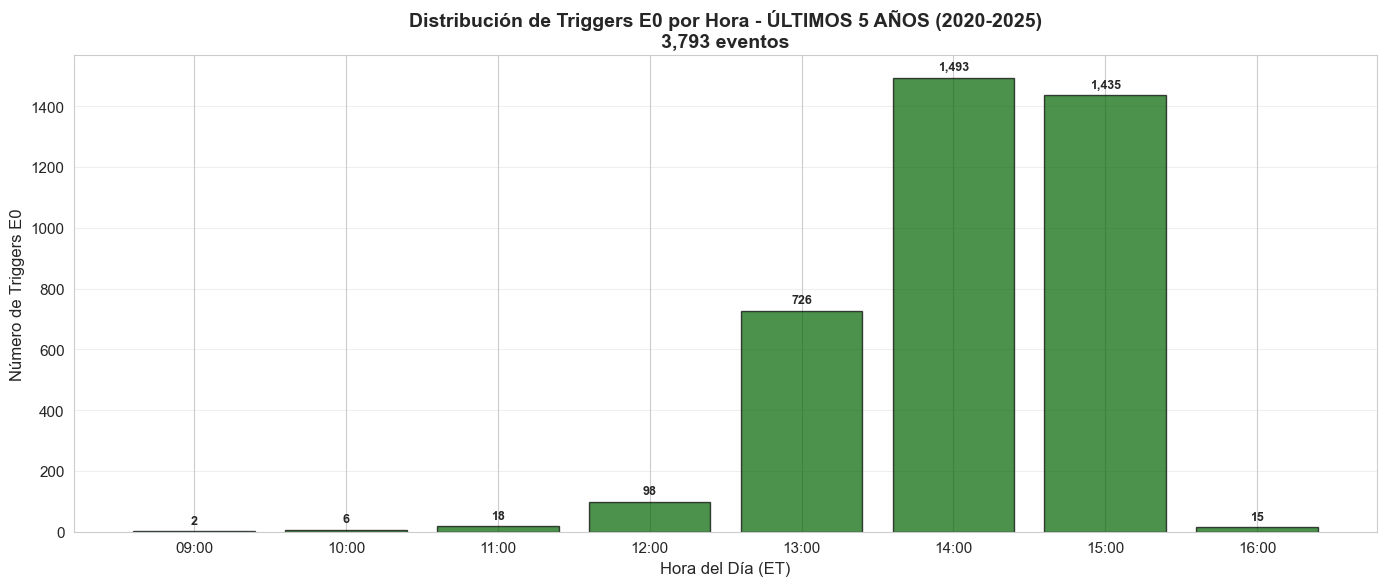


✅ Gráfico guardado: e0_triggers_por_hora_2020_2025.png

✅ CSV exportado: eventos_E0_CON_HORA_EXACTA_2020_2025_TRADINGVIEW.csv
   Total triggers: 3,793

📋 Sample (primeros 10):
shape: (10, 8)
┌────────┬────────────┬────────────┬────────────┬────────────┬────────────┬────────────┬───────────┐
│ ticker ┆ date       ┆ trigger_ti ┆ trigger_ho ┆ trigger_mi ┆ pctchg_tri ┆ dvol_trigg ┆ close_tri │
│ ---    ┆ ---        ┆ me         ┆ ur         ┆ nute       ┆ gger       ┆ er         ┆ gger      │
│ str    ┆ str        ┆ ---        ┆ ---        ┆ ---        ┆ ---        ┆ ---        ┆ ---       │
│        ┆            ┆ datetime[μ ┆ i64        ┆ i64        ┆ f64        ┆ f64        ┆ f64       │
│        ┆            ┆ s]         ┆            ┆            ┆            ┆            ┆           │
╞════════╪════════════╪════════════╪════════════╪════════════╪════════════╪════════════╪═══════════╡
│ ONCY   ┆ 2020-01-02 ┆ 2020-01-02 ┆ 15         ┆ 39         ┆ -0.152083  ┆ 7.3494e6   ┆ 4.07      │


In [11]:
# ========================================================================
# NUEVA CELDA 19: ANÁLISIS ÚLTIMOS 5 AÑOS (2020-2025)
# ========================================================================

from datetime import datetime

print("="*80)
print("ANÁLISIS E0: ÚLTIMOS 5 AÑOS (2020-2025)")
print("="*80)

# Filtrar df_e0 (ya existe de la celda anterior) para últimos 5 años
cutoff_date = datetime(2020, 1, 1).date()

df_e0_last5y = df_e0.filter(
    pl.col('trading_day') >= cutoff_date
)

print(f"\n✅ Eventos E0 filtrados:")
print(f"   Período: 2020-01-01 → {df_e0_last5y['trading_day'].max()}")
print(f"   Total eventos: {len(df_e0_last5y):,}")
print(f"   Tickers únicos: {df_e0_last5y['ticker'].n_unique():,}")
print(f"   % del total E0: {len(df_e0_last5y)/len(df_e0)*100:.1f}%")

# Usar la misma función detectar_trigger_intraday (ya definida en celda anterior)
# y las mismas variables: TRADES_DIR, OUTPUT_DIR

print(f"\n🚀 Procesamiento SERIAL iniciando (últimos 5 años)...")
print(f"   Estimado de tiempo: ~{len(df_e0_last5y)//4800:.0f}-{len(df_e0_last5y)//2400:.0f} minutos")

# Procesar CON PROGRESO
triggers_5y = []
results_5y = []

for row in tqdm(df_e0_last5y.iter_rows(named=True),
                total=len(df_e0_last5y),
                desc="Analizando triggers (5y)",
                unit="evento"):
    result = detectar_trigger_intraday(row['ticker'], row['trading_day'], TRADES_DIR)
    results_5y.append(result)
    if result is not None:
        triggers_5y.append(result)

processed_5y = len(results_5y)
found_5y = len(triggers_5y)

print(f"\n✅ Análisis completado (2020-2025):")
print(f"   Eventos analizados: {processed_5y:,}")
print(f"   Triggers encontrados: {found_5y:,}")
print(f"   % con trades disponibles: {found_5y/processed_5y*100:.1f}%")

if len(triggers_5y) > 0:
    df_triggers_5y = pl.DataFrame(triggers_5y)
    
    print("\n📊 ESTADÍSTICAS DE TRIGGERS (2020-2025):")
    print(f"   Hora promedio trigger: {df_triggers_5y['trigger_hour'].mean():.1f}:{df_triggers_5y['trigger_minute'].mean():.0f}")
    
    # Distribución por hora
    by_hour_5y = df_triggers_5y.group_by('trigger_hour').agg(pl.count().alias('count')).sort('trigger_hour')
    
    print("\n📊 DISTRIBUCIÓN POR HORA DEL DÍA (2020-2025):")
    for row in by_hour_5y.iter_rows(named=True):
        hour = row['trigger_hour']
        count = row['count']
        pct = count / len(df_triggers_5y) * 100
        print(f"   {hour:02d}:00 - {hour:02d}:59: {count:>6,} triggers ({pct:>5.1f}%)")
    
    # Gráfico
    fig, ax = plt.subplots(figsize=(14, 6))
    by_hour_5y_pd = by_hour_5y.to_pandas()
    
    ax.bar(by_hour_5y_pd['trigger_hour'], by_hour_5y_pd['count'], color='darkgreen', alpha=0.7, edgecolor='black')
    ax.set_xlabel('Hora del Día (ET)', fontsize=12)
    ax.set_ylabel('Número de Triggers E0', fontsize=12)
    ax.set_title(f'Distribución de Triggers E0 por Hora - ÚLTIMOS 5 AÑOS (2020-2025)\n{len(df_triggers_5y):,} eventos', 
                 fontsize=14, fontweight='bold')
    ax.set_xticks(range(9, 17))
    ax.set_xticklabels([f'{h:02d}:00' for h in range(9, 17)])
    ax.grid(axis='y', alpha=0.3)
    
    for i, (hour, count) in enumerate(zip(by_hour_5y_pd['trigger_hour'], by_hour_5y_pd['count'])):
        ax.text(hour, count + max(by_hour_5y_pd['count'])*0.01, f'{count:,}', 
                ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'e0_triggers_por_hora_2020_2025.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n✅ Gráfico guardado: e0_triggers_por_hora_2020_2025.png")
    
    # Exportar CSV con hora exacta (2020-2025)
    df_export_triggers_5y = df_triggers_5y.select([
        'ticker',
        'date',
        'trigger_time',
        'trigger_hour',
        'trigger_minute',
        'pctchg_trigger',
        'dvol_trigger',
        'close_trigger'
    ]).sort(['date', 'trigger_time'])
    
    csv_triggers_5y = OUTPUT_DIR / 'eventos_E0_CON_HORA_EXACTA_2020_2025_TRADINGVIEW.csv'
    df_export_triggers_5y.write_csv(csv_triggers_5y)
    
    print(f"\n✅ CSV exportado: {csv_triggers_5y.name}")
    print(f"   Total triggers: {len(df_export_triggers_5y):,}")
    print(f"\n📋 Sample (primeros 10):") 
    print(df_export_triggers_5y.head(10))
    
    best_hour_5y = by_hour_5y_pd.loc[by_hour_5y_pd['count'].idxmax()]
    print(f"\n🏆 MEJOR HORA (2020-2025): {best_hour_5y['trigger_hour']:02d}:00 con {best_hour_5y['count']:,} triggers ({best_hour_5y['count']/len(df_triggers_5y)*100:.1f}%)")
    
else:
    print("\n⚠️  No se encontraron triggers en 2020-2025")

In [ ]:
# ========================================================================
# CELDA INTERACTIVA: SELECTOR DINÁMICO E0 + 4 PANELES (BARRAS DIB AJUSTADAS)
# ========================================================================

import ipywidgets as widgets
from IPython.display import display, clear_output
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from datetime import datetime, timedelta
import matplotlib.gridspec as gridspec
import pytz

# Definir zona horaria de Nueva York
ET = pytz.timezone('America/New_York')

# Cargar el CSV de triggers
csv_triggers_5y = OUTPUT_DIR / 'data' / 'eventos_E0_CON_HORA_EXACTA_2020_2025_TRADINGVIEW.csv'

if not csv_triggers_5y.exists():
    print(f"❌ No se encontró: {csv_triggers_5y}")
else:
    df_triggers_csv = pl.read_csv(csv_triggers_5y)
    
    print("="*80)
    print("SELECTOR INTERACTIVO DE EVENTOS E0 - 4 PANELES")
    print("="*80)
    print(f"\n✅ Cargados {len(df_triggers_csv):,} triggers (2020-2025)")
    print(f"✅ Zona horaria: America/New_York (Eastern Time)")
    
    # ===== FUNCIÓN DE VISUALIZACIÓN CON 4 PANELES =====
    
    def plot_complete_analysis(ticker, date_str, trigger_hour, trigger_minute, 
                               pctchg_trigger, dvol_trigger, close_trigger):
        """
        Visualiza análisis completo con 4 paneles:
        1. Daily OHLCV (±30 días)
        2. Intraday 1-min
        3. DIB bars (ancho ajustado)
        4. Volume
        """
        
        date_obj = datetime.strptime(date_str, '%Y-%m-%d')
        year = date_obj.year
        month = f"{date_obj.month:02d}"
        
        # ================================================================
        # CARGAR DATOS
        # ================================================================
        
        # 1. Daily OHLCV
        daily_file = PROJECT_ROOT / "processed" / "daily_ohlcv" / ticker / "daily.parquet"
        df_daily_pd = None
        
        if daily_file.exists():
            df_daily = pl.read_parquet(daily_file)
            df_daily_pd = df_daily.to_pandas()
            df_daily_pd['timestamp'] = pd.to_datetime(df_daily_pd['date']).dt.tz_localize(ET)
            
            # Filtrar ±30 días
            event_date_tz = pd.Timestamp(date_obj, tz=ET)
            start_date = event_date_tz - timedelta(days=30)
            end_date = event_date_tz + timedelta(days=30)
            df_daily_pd = df_daily_pd[(df_daily_pd['timestamp'] >= start_date) &
                                      (df_daily_pd['timestamp'] <= end_date)]
            df_daily_pd = df_daily_pd.sort_values('timestamp').reset_index(drop=True)
        
        # 2. Intraday 1-min
        minute_file = PROJECT_ROOT / "raw" / "polygon" / "ohlcv_intraday_1m" / ticker / f"year={year}" / f"month={month}" / "minute.parquet"
        
        if not minute_file.exists():
            print(f"❌ No se encontró archivo: {minute_file}")
            return None
        
        df_1m = pl.read_parquet(minute_file)
        df_1m = df_1m.with_columns([
            (pl.col('t') / 1000).cast(pl.Int64).alias('t_seconds')
        ])
        df_1m = df_1m.with_columns([
            pl.from_epoch(pl.col('t_seconds'), time_unit='s').alias('timestamp_utc')
        ])
        
        df_1m_pd = df_1m.to_pandas()
        df_1m_pd['timestamp'] = pd.to_datetime(df_1m_pd['timestamp_utc']).dt.tz_localize('UTC').dt.tz_convert(ET)
        
        # Filtrar día y RTH
        df_day = df_1m_pd[df_1m_pd['timestamp'].dt.date == date_obj.date()]
        df_day = df_day[
            ((df_day['timestamp'].dt.hour == 9) & (df_day['timestamp'].dt.minute >= 30)) |
            ((df_day['timestamp'].dt.hour >= 10) & (df_day['timestamp'].dt.hour < 16)) |
            ((df_day['timestamp'].dt.hour == 16) & (df_day['timestamp'].dt.minute == 0))
        ].reset_index(drop=True)
        
        if len(df_day) == 0:
            print(f"❌ No hay datos para {ticker} en {date_str}")
            return None
        
        # 3. DIB bars
        dib_file = PROJECT_ROOT / "processed" / "bars" / ticker / f"date={date_str}" / "dollar_imbalance.parquet"
        df_dib_pd = None
        
        if dib_file.exists():
            df_dib = pl.read_parquet(dib_file)
            df_dib_pd = df_dib.to_pandas()
            df_dib_pd['timestamp'] = pd.to_datetime(df_dib_pd['t_close'], unit='ns', utc=True).dt.tz_convert(ET)
            df_dib_pd = df_dib_pd.sort_values('timestamp').reset_index(drop=True)
        
        # ================================================================
        # CREAR FIGURA CON 4 PANELES
        # ================================================================
        
        # Determinar si hay DIB
        has_dib = df_dib_pd is not None and len(df_dib_pd) > 0
        has_daily = df_daily_pd is not None and len(df_daily_pd) > 0
        
        # Altura total ajustada
        n_panels = 2  # Siempre intraday + volume
        if has_daily:
            n_panels += 1
        if has_dib:
            n_panels += 1
        
        fig = plt.figure(figsize=(20, 6 * n_panels))
        
        # Configurar gridspec con ratios apropiados
        if n_panels == 4:
            gs = gridspec.GridSpec(4, 1, height_ratios=[1.2, 1.5, 1.5, 0.8], hspace=0.4)
        elif n_panels == 3 and has_daily:
            gs = gridspec.GridSpec(3, 1, height_ratios=[1.2, 1.5, 0.8], hspace=0.4)
        elif n_panels == 3 and has_dib:
            gs = gridspec.GridSpec(3, 1, height_ratios=[1.5, 1.5, 0.8], hspace=0.4)
        else:
            gs = gridspec.GridSpec(2, 1, height_ratios=[1.5, 0.8], hspace=0.4)
        
        panel_idx = 0
        trigger_time = ET.localize(datetime.strptime(f"{date_str} {trigger_hour:02d}:{trigger_minute:02d}:00",
                                                     '%Y-%m-%d %H:%M:%S'))
        
        # ----------------------------------------------------------------
        # PANEL 1: DAILY OHLCV
        # ----------------------------------------------------------------
        if has_daily:
            ax_daily = fig.add_subplot(gs[panel_idx])
            panel_idx += 1
            
            for _, row in df_daily_pd.iterrows():
                color = 'green' if row['c'] >= row['o'] else 'red'
                ax_daily.plot([row['timestamp'], row['timestamp']], [row['l'], row['h']],
                             color=color, linewidth=1.5, alpha=0.8)
                
                height = abs(row['c'] - row['o'])
                bottom = min(row['o'], row['c'])
                ts_num = mdates.date2num(row['timestamp'])
                ax_daily.add_patch(Rectangle((ts_num - 0.3, bottom), 0.6, height,
                                            facecolor=color, edgecolor=color, alpha=0.7))
            
            event_date_tz = pd.Timestamp(date_obj, tz=ET)
            ax_daily.axvline(event_date_tz, color='orange', linestyle='--', linewidth=3,
                            label=f'Evento E0: {date_str}', alpha=0.9)
            
            ax_daily.set_ylabel('Precio ($)', fontsize=13, fontweight='bold')
            ax_daily.set_title(f'{ticker} - Gráfico Diario (±30 días) | Evento: {date_str}',
                              fontsize=15, fontweight='bold', pad=20)
            ax_daily.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d', tz=ET))
            ax_daily.xaxis.set_major_locator(mdates.DayLocator(interval=5))
            ax_daily.grid(True, alpha=0.3)
            ax_daily.legend(loc='upper left', fontsize=11)
            plt.setp(ax_daily.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        # ----------------------------------------------------------------
        # PANEL 2: INTRADAY 1-MIN
        # ----------------------------------------------------------------
        ax_1m = fig.add_subplot(gs[panel_idx])
        panel_idx += 1
        
        colors_1m = ['green' if row['c'] >= row['o'] else 'red' for _, row in df_day.iterrows()]
        
        for idx, row in df_day.iterrows():
            ax_1m.plot([row['timestamp'], row['timestamp']], [row['l'], row['h']],
                       color=colors_1m[idx], linewidth=1, alpha=0.8)
            
            height = abs(row['c'] - row['o'])
            bottom = min(row['o'], row['c'])
            ts_num = mdates.date2num(row['timestamp'])
            ax_1m.add_patch(Rectangle((ts_num - 0.0003, bottom), 0.0006, height,
                                     facecolor=colors_1m[idx], edgecolor=colors_1m[idx], alpha=0.7))
        
        ax_1m.axvline(trigger_time, color='orange', linestyle='--', linewidth=2.5,
                     label='Trigger E0', alpha=0.9)
        ax_1m.axhline(close_trigger, color='orange', linestyle=':', linewidth=1, alpha=0.5)
        
        ax_1m.annotate(f'E0 TRIGGER\n{trigger_hour:02d}:{trigger_minute:02d} ET\n${close_trigger:.2f}\n{pctchg_trigger*100:.1f}%',
                      xy=(trigger_time, close_trigger), xytext=(10, 30), textcoords='offset points',
                      bbox=dict(boxstyle='round,pad=0.5', fc='orange', alpha=0.7),
                      arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='orange'),
                      fontsize=11, fontweight='bold')
        
        ax_1m.set_ylabel('Precio ($)', fontsize=13, fontweight='bold')
        ax_1m.set_title(f'{ticker} - Intraday 1-Minuto (RTH) | {date_str}',
                       fontsize=15, fontweight='bold', pad=20)
        ax_1m.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=ET))
        ax_1m.xaxis.set_major_locator(mdates.HourLocator(interval=1, tz=ET))
        ax_1m.grid(True, alpha=0.3)
        ax_1m.legend(loc='upper left', fontsize=11)
        plt.setp(ax_1m.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        # ----------------------------------------------------------------
        # PANEL 3: DIB BARS (ANCHO AJUSTADO DINÁMICAMENTE)
        # ----------------------------------------------------------------
        if has_dib:
            ax_dib = fig.add_subplot(gs[panel_idx])
            panel_idx += 1
            
            colors_dib = ['green' if row['c'] >= row['o'] else 'red' for _, row in df_dib_pd.iterrows()]
            
            # ✅ CALCULAR ANCHO DE BARRA DINÁMICAMENTE
            # Objetivo: hacer las barras proporcionales al espacio disponible
            if len(df_dib_pd) > 1:
                # Calcular el tiempo promedio entre barras
                timestamps = df_dib_pd['timestamp']
                time_diffs = [(timestamps.iloc[i+1] - timestamps.iloc[i]).total_seconds() 
                             for i in range(len(timestamps)-1)]
                avg_time_diff = sum(time_diffs) / len(time_diffs)
                
                # Convertir a fracción de día (matplotlib usa días como unidad)
                bar_width_days = (avg_time_diff * 0.7) / 86400  # 70% del espacio entre barras
            else:
                bar_width_days = 0.002  # Valor por defecto
            
            for idx, row in df_dib_pd.iterrows():
                # Wicks
                ax_dib.plot([row['timestamp'], row['timestamp']], [row['l'], row['h']],
                           color=colors_dib[idx], linewidth=1.5, alpha=0.8)
                
                # Body con ancho ajustado
                height = abs(row['c'] - row['o'])
                bottom = min(row['o'], row['c'])
                ts_num = mdates.date2num(row['timestamp'])
                ax_dib.add_patch(Rectangle((ts_num - bar_width_days/2, bottom), 
                                          bar_width_days, height,
                                          facecolor=colors_dib[idx], 
                                          edgecolor=colors_dib[idx], 
                                          alpha=0.7,
                                          linewidth=0.5))
            
            ax_dib.axvline(trigger_time, color='orange', linestyle='--', linewidth=2.5,
                          label='Trigger E0', alpha=0.9)
            
            ax_dib.set_ylabel('Precio ($)', fontsize=13, fontweight='bold')
            ax_dib.set_title(f'{ticker} - Dollar Imbalance Bars (DIB) | {date_str} | {len(df_dib_pd)} barras',
                            fontsize=15, fontweight='bold', pad=20)
            ax_dib.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=ET))
            ax_dib.xaxis.set_major_locator(mdates.HourLocator(interval=1, tz=ET))
            ax_dib.grid(True, alpha=0.3)
            ax_dib.legend(loc='upper left', fontsize=11)
            plt.setp(ax_dib.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        # ----------------------------------------------------------------
        # PANEL 4: VOLUME
        # ----------------------------------------------------------------
        ax_vol = fig.add_subplot(gs[panel_idx])
        
        ax_vol.bar(df_day['timestamp'], df_day['v'], width=pd.Timedelta(minutes=0.8),
                   color=colors_1m, alpha=0.7)
        ax_vol.axvline(trigger_time, color='orange', linestyle='--', linewidth=2.5, alpha=0.9)
        
        ax_vol.annotate(f'$vol: ${dvol_trigger/1e6:.2f}M',
                       xy=(trigger_time, df_day['v'].max()*0.8), xytext=(10, -20),
                       textcoords='offset points',
                       bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.6),
                       fontsize=10, fontweight='bold')
        
        ax_vol.set_ylabel('Volumen', fontsize=13, fontweight='bold')
        ax_vol.set_xlabel('Hora (ET - Eastern Time)', fontsize=13, fontweight='bold')
        ax_vol.set_title(f'{ticker} - Volumen Intradiario | {date_str}',
                        fontsize=15, fontweight='bold', pad=20)
        ax_vol.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=ET))
        ax_vol.xaxis.set_major_locator(mdates.HourLocator(interval=1, tz=ET))
        ax_vol.grid(True, alpha=0.3)
        plt.setp(ax_vol.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
        
        # ================================================================
        # ESTADÍSTICAS
        # ================================================================
        print(f"\n{'='*80}")
        print(f"📊 ESTADÍSTICAS - {ticker} | {date_str}")
        print(f"{'='*80}")
        
        if has_daily:
            print(f"\n📅 CONTEXTO DIARIO:")
            print(f"   Días en ventana: {len(df_daily_pd)}")
        
        print(f"\n📈 INTRADAY 1-MIN:")
        print(f"   Barras: {len(df_day)}")
        print(f"   Open: ${df_day['o'].iloc[0]:.2f}")
        print(f"   High: ${df_day['h'].max():.2f}")
        print(f"   Low: ${df_day['l'].min():.2f}")
        print(f"   Close: ${df_day['c'].iloc[-1]:.2f}")
        print(f"   Volume: {df_day['v'].sum():,.0f}")
        print(f"   Range: {((df_day['h'].max() - df_day['l'].min()) / df_day['o'].iloc[0] * 100):.1f}%")
        
        if has_dib:
            print(f"\n📊 DIB BARS:")
            print(f"   Total barras DIB: {len(df_dib_pd)}")
            print(f"   Promedio barras/hora: {len(df_dib_pd) / 6.5:.1f}")
            print(f"   Dollar volume: ${df_dib_pd['dollar'].sum():,.0f}")
            if len(df_dib_pd) > 1:
                print(f"   Tiempo promedio entre barras: {avg_time_diff:.1f} segundos")
        
        print(f"\n{'='*80}")
        
        return df_day
    
    # ===== WIDGETS INTERACTIVOS =====
    
    ticker_counts = df_triggers_csv.group_by('ticker').agg(pl.count().alias('count')).sort('ticker')
    ticker_counts_pd = ticker_counts.to_pandas()
    ticker_options = [(f"{row.ticker} ({row.count} eventos)", row.ticker) 
                      for row in ticker_counts_pd.itertuples(index=False)]
    
    ticker_dropdown = widgets.Dropdown(
        options=ticker_options,
        description='Ticker:',
        style={'description_width': '100px'},
        layout=widgets.Layout(width='300px')
    )
    
    date_dropdown = widgets.Dropdown(
        description='Fecha:',
        style={'description_width': '100px'},
        layout=widgets.Layout(width='300px')
    )
    
    time_dropdown = widgets.Dropdown(
        description='Trigger:',
        style={'description_width': '100px'},
        layout=widgets.Layout(width='400px')
    )
    
    plot_button = widgets.Button(
        description='📊 GRAFICAR 4 PANELES',
        button_style='success',
        layout=widgets.Layout(width='250px', height='40px')
    )
    
    output_area = widgets.Output()
    
    # ===== LÓGICA DE ACTUALIZACIÓN =====
    
    def update_dates(change):
        ticker = change['new']
        dates = df_triggers_csv.filter(pl.col('ticker') == ticker)['date'].unique().sort()
        date_dropdown.options = [(d, d) for d in dates.to_list()]
        if len(dates) > 0:
            date_dropdown.value = dates[0]
    
    def update_times(change):
        ticker = ticker_dropdown.value
        date = change['new']
        
        events = df_triggers_csv.filter(
            (pl.col('ticker') == ticker) & (pl.col('date') == date)
        ).to_pandas()
        
        time_options = []
        for row in events.itertuples(index=False):
            label = f"{row.trigger_hour:02d}:{row.trigger_minute:02d} ET | ${row.close_trigger:.2f} | {row.pctchg_trigger*100:+.1f}%"
            time_options.append((label, row))
        
        time_dropdown.options = time_options
        if len(time_options) > 0:
            time_dropdown.value = time_options[0][1]
    
    def plot_selected(button):
        with output_area:
            clear_output(wait=True)
            
            ticker = ticker_dropdown.value
            event = time_dropdown.value
            
            print(f"🚀 Graficando 4 paneles: {ticker} | {event.date} | {event.trigger_hour:02d}:{event.trigger_minute:02d} ET")
            print("="*80)
            
            plot_complete_analysis(
                ticker=ticker,
                date_str=event.date,
                trigger_hour=event.trigger_hour,
                trigger_minute=event.trigger_minute,
                pctchg_trigger=event.pctchg_trigger,
                dvol_trigger=event.dvol_trigger,
                close_trigger=event.close_trigger
            )
    
    # Conectar eventos
    ticker_dropdown.observe(update_dates, names='value')
    date_dropdown.observe(update_times, names='value')
    plot_button.on_click(plot_selected)
    
    # Inicializar
    if len(ticker_options) > 0:
        ticker_dropdown.value = ticker_options[0][1]
    
    # ===== MOSTRAR UI =====
    
    print("\n📋 INSTRUCCIONES:")
    print("1. Selecciona un TICKER")
    print("2. Selecciona una FECHA (actualización automática)")
    print("3. Selecciona un TRIGGER (hora en ET)")
    print("4. Click en 'GRAFICAR 4 PANELES'")
    print("\n✨ Se mostrarán: Daily + Intraday 1-min + DIB + Volume")
    print("⏰ Todas las horas en ET (Eastern Time - Nueva York)\n")
    
    display(widgets.VBox([
        widgets.HBox([ticker_dropdown, date_dropdown]),
        time_dropdown,
        plot_button,
        output_area
    ]))

SELECTOR INTERACTIVO DE EVENTOS E0 - 4 PANELES

✅ Cargados 3,793 triggers (2020-2025)
✅ Zona horaria: America/New_York (Eastern Time)

📋 INSTRUCCIONES:
1. Selecciona un TICKER
2. Selecciona una FECHA (actualización automática)
3. Selecciona un TRIGGER (hora en ET)
4. Click en 'GRAFICAR 4 PANELES'

✨ Se mostrarán: Daily + Intraday 1-min + DIB + Volume
⏰ Todas las horas en ET (Eastern Time - Nueva York)

